In [81]:
import pandas as pd

df = pd.read_csv('analyze data.csv', index_col=0)

df_country_median = (
    df.groupby(["country_code","country_name"], as_index=False)
      .agg({
          'log_child_employment_rate': 'median',
          'agriculture_value_added_pct': 'median',
          'life_expectancy': 'median',
          'urban_population_pct': 'median',
          'rural_electricity_access': 'median',
      })
)
base_features = ['agriculture_value_added_pct',
          'life_expectancy',
          'urban_population_pct',
          'rural_electricity_access',]
target = "log_child_employment_rate"
df_clean = df_country_median.dropna(subset=[target]+ base_features)
len(df_clean)

print(f"Final veri: {len(df_clean)} ülke, {len(base_features)} özellik")

Final veri: 78 ülke, 4 özellik


# 🔍 CLUSTERING ANALİZİ: ÜLKE PROFİLLERİ

**Amaç**: Regresyondan öğrendiğimiz 4 kritik değişkeni kullanarak ülkeleri gruplara ayırıp profil oluşturmak.

**Kullanılacak Değişkenler** (Lasso seçimi + target):
1. `agriculture_value_added_pct` - Tarımsal bağımlılık  
2. `life_expectancy` - Sağlık/gelişmişlik göstergesi
3. `urban_population_pct` - Kentleşme düzeyi
4. `rural_electricity_access` - Altyapı erişimi
5. `log_child_employment_rate` - Çocuk istihdamı (hedef)

**Yöntem**: K-Means clustering + PCA görselleştirme + İstatistiksel validasyon


In [82]:
# Kütüphaneler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.stats import f_oneway

print("✅ Kütüphaneler yüklendi")


✅ Kütüphaneler yüklendi


In [83]:
# 1️⃣ Özellik seçimi ve standardizasyon
features = [
    'agriculture_value_added_pct',
    'life_expectancy',
    'urban_population_pct',
    'rural_electricity_access',
]

X = df_clean[features].dropna()

# Standardize et
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Ülke sayısı: {X.shape[0]} | Özellik sayısı: {len(features)}")
print("✅ Veri standardize edildi (adil mesafe ölçümü için)\n")
print(f"Veri boyutu: {X.shape}")


Ülke sayısı: 78 | Özellik sayısı: 4
✅ Veri standardize edildi (adil mesafe ölçümü için)

Veri boyutu: (78, 4)


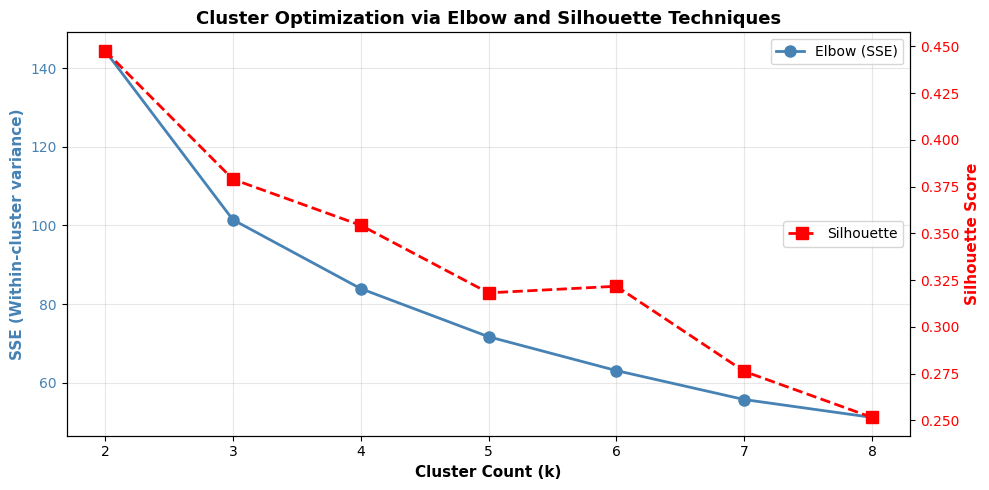


📊 Seçilen cluster sayısı: k=2
   • En yüksek Silhouette Score: 0.448
   • İlgili SSE: 144.46


In [84]:
# 3️⃣ Optimal cluster sayısını belirle
sse, sil = [], []
K = range(2, 9)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_scaled)
    sse.append(km.inertia_)
    sil.append(silhouette_score(X_scaled, km.labels_))

# Görselleştirme
fig, ax1 = plt.subplots(figsize=(10, 5))

# Elbow curve
ax1.plot(K, sse, 'o-', label='Elbow (SSE)', color='steelblue', linewidth=2, markersize=8)
ax1.set_xlabel("Cluster Count (k)", fontweight='bold', fontsize=11)
ax1.set_ylabel("SSE (Within-cluster variance)", fontweight='bold', fontsize=11, color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.grid(True, alpha=0.3)

# Silhouette score
ax2 = ax1.twinx()
ax2.plot(K, sil, 's--', label='Silhouette', color='red', linewidth=2, markersize=8)
ax2.set_ylabel("Silhouette Score", fontweight='bold', fontsize=11, color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title("Cluster Optimization via Elbow and Silhouette Techniques", fontsize=13, fontweight='bold')
ax1.legend(loc='upper right', fontsize=10)
ax2.legend(loc='center right', fontsize=10)
plt.tight_layout()
plt.savefig('cluster_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

# En iyi k'yi seç
best_k = sil.index(max(sil)) + 2  # +2 çünkü range(2,9)
print(f"\n📊 Seçilen cluster sayısı: k={best_k}")
print(f"   • En yüksek Silhouette Score: {max(sil):.3f}")
print(f"   • İlgili SSE: {sse[best_k-2]:.2f}")


In [85]:
# 4️⃣ Final K-Means modeli
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Cluster bilgilerini dataframe'e ekle
df_clusters = X.copy()
df_clusters['cluster'] = clusters

print(f"\n✅ K-Means modeli fit edildi")
print(f"   • Cluster sayısı: {best_k}")
print(f"   • Toplam ülke: {len(df_clusters)}")
print(f"\n📊 Cluster dağılımı:")
print(df_clusters['cluster'].value_counts().sort_index())



✅ K-Means modeli fit edildi
   • Cluster sayısı: 2
   • Toplam ülke: 78

📊 Cluster dağılımı:
cluster
0    35
1    43
Name: count, dtype: int64


In [86]:
# 5️⃣ Cluster özeti (ortalama değerler)
summary = df_clusters.groupby('cluster').mean().round(2)
summary['n_countries'] = df_clusters['cluster'].value_counts().sort_index().values

print("\n" + "="*90)
print(" "*30 + "📈 CLUSTER ÖZETİ")
print("="*90)
print("\nCluster Ortalamaları (Ham Değerler):")
print(summary.to_string())

print("\n💡 Yorumlama:")
print("   • Her cluster farklı sosyoekonomik profili temsil ediyor")
print("   • Ortalamalar ham değerlerde (standardize edilmemiş)")
print("   • n_countries: Her cluster'daki ülke sayısı")



                              📈 CLUSTER ÖZETİ

Cluster Ortalamaları (Ham Değerler):
         agriculture_value_added_pct  life_expectancy  urban_population_pct  rural_electricity_access  n_countries
cluster                                                                                                           
0                              23.44            61.20                 35.14                     32.02           35
1                               9.92            72.35                 58.93                     92.24           43

💡 Yorumlama:
   • Her cluster farklı sosyoekonomik profili temsil ediyor
   • Ortalamalar ham değerlerde (standardize edilmemiş)
   • n_countries: Her cluster'daki ülke sayısı


In [87]:
# 6️⃣ İstatistiksel validasyon: One-way ANOVA
print("\n" + "="*90)
print(" "*30 + "📊 ANOVA TEST")
print("="*90)
print("\n Feature-wise differences across clusters\n")

for col in features:
    groups = [df_clusters[df_clusters['cluster']==i][col] for i in range(best_k)]
    f_stat, p_val = f_oneway(*groups)
    significance = "✅ Statistically significant" if p_val < 0.05 else "⚠️  Statistically insignificant"
    print(f"{col:.<50} F={f_stat:>6.2f}, p={p_val:.4f} {significance}")

print("\n  p < 0.05 → Clusters show a statistically significant difference in this feature.")
print("  High F-statistic → Large variance between clusters. ")



                              📊 ANOVA TEST

 Feature-wise differences across clusters

agriculture_value_added_pct....................... F= 86.22, p=0.0000 ✅ Statistically significant
life_expectancy................................... F=117.05, p=0.0000 ✅ Statistically significant
urban_population_pct.............................. F= 42.72, p=0.0000 ✅ Statistically significant
rural_electricity_access.......................... F=141.28, p=0.0000 ✅ Statistically significant

  p < 0.05 → Clusters show a statistically significant difference in this feature.
  High F-statistic → Large variance between clusters. 


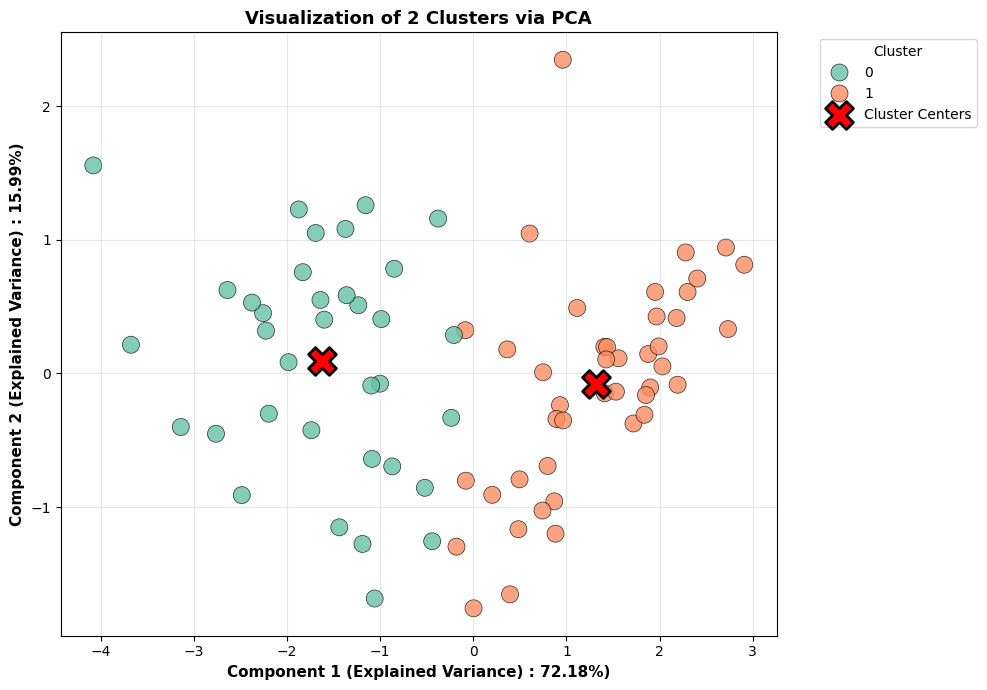


✅ PCA görselleştirmesi oluşturuldu
   • Toplam açıklanan varyans: 88.17%


In [88]:
# 7️⃣ PCA 2D görselleştirme
pca = PCA(n_components=2)
coords = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
scatter = sns.scatterplot(x=coords[:,0], y=coords[:,1], 
                          hue=clusters, palette='Set2', 
                          s=150, edgecolor='black', linewidth=0.5, alpha=0.8)

# Cluster merkezlerini ekle
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], 
           marker='X', s=400, c='red', edgecolors='black', linewidth=2,
           label='Cluster Centers', zorder=5)

plt.xlabel(f"Component 1 (Explained Variance) : {pca.explained_variance_ratio_[0]:.2%})", 
          fontweight='bold', fontsize=11)
plt.ylabel(f"Component 2 (Explained Variance) : {pca.explained_variance_ratio_[1]:.2%})", 
          fontweight='bold', fontsize=11)
plt.title(f"Visualization of {best_k} Clusters via PCA", fontsize=13, fontweight='bold')
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('cluster_pca.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ PCA görselleştirmesi oluşturuldu")
print(f"   • Toplam açıklanan varyans: {sum(pca.explained_variance_ratio_):.2%}")


PCA'da Açıklanan Varyans (PVE) Nedir?
Açıklanan Varyans Oranı (Proportion of Variance Explained - PVE) veya kısaca varyans, Temel Bileşenler Analizi'nin (PCA) temel çıktılarından biridir ve her bir temel bileşenin (PC) orijinal veri kümesindeki toplam değişkenliği ne kadar yakaladığını gösterir



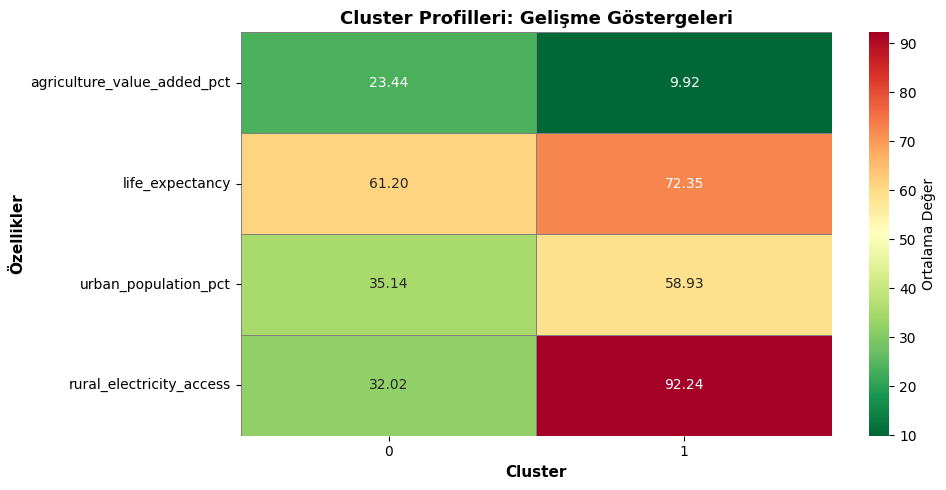


✅ Cluster heatmap oluşturuldu


In [89]:
# 8️⃣ Cluster heatmap (profil analizi)
plt.figure(figsize=(10, 5))

# Standardize edilmiş ortalamaları al
summary_std = df_clusters.groupby('cluster')[features].mean()

# Heatmap oluştur
sns.heatmap(summary_std.T, cmap='RdYlGn_r', annot=True, fmt=".2f", 
           cbar_kws={'label': 'Ortalama Değer'},
           linewidths=0.5, linecolor='gray')

plt.title("Cluster Profilleri: Gelişme Göstergeleri", fontsize=13, fontweight='bold')
plt.xlabel("Cluster", fontweight='bold', fontsize=11)
plt.ylabel("Özellikler", fontweight='bold', fontsize=11)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('cluster_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Cluster heatmap oluşturuldu")


In [90]:
print("Summary sütunları:", summary.columns.tolist())
print("Summary shape:", summary.shape)
summary.head()


Summary sütunları: ['agriculture_value_added_pct', 'life_expectancy', 'urban_population_pct', 'rural_electricity_access', 'n_countries']
Summary shape: (2, 5)


,agriculture_value_added_pct,life_expectancy,urban_population_pct,rural_electricity_access,n_countries
cluster,,,,,
0,23.44,61.20,35.14,32.02,35
1,9.92,72.35,58.93,92.24,43


In [91]:

df_clusters['log_child_employment_rate'] = df_clean.loc[X.index, 'log_child_employment_rate'].values
summary['log_child_employment_rate'] = df_clusters.groupby('cluster')['log_child_employment_rate'].mean().round(2)


print("Summary sütunları:", summary.columns.tolist())
print("Summary shape:", summary.shape)
summary.head()

Summary sütunları: ['agriculture_value_added_pct', 'life_expectancy', 'urban_population_pct', 'rural_electricity_access', 'n_countries', 'log_child_employment_rate']
Summary shape: (2, 6)


,agriculture_value_added_pct,life_expectancy,urban_population_pct,rural_electricity_access,n_countries,log_child_employment_rate
cluster,,,,,,
0,23.44,61.20,35.14,32.02,35,2.51
1,9.92,72.35,58.93,92.24,43,1.60


In [92]:
# 9️⃣ Cluster yorumlama
print("\n" + "="*90)
print(" "*30 + "🧠 CLUSTER YORUMLAMA")
print("="*90)

for i in range(best_k):
    row = summary.iloc[i]
    print(f"\n{'='*50}")
    print(f"CLUSTER {i} ({int(row['n_countries'])} ülke)")
    print('='*50)
    
    # Yaşam beklentisi
    if row['life_expectancy'] > summary['life_expectancy'].mean():
        print("  ✅ Yüksek yaşam beklentisi (sağlıklı nüfus)")
    else:
        print("  ⚠️  Düşük yaşam beklentisi")
    
    # Kentleşme
    if row['urban_population_pct'] > summary['urban_population_pct'].mean():
        print("  🏙️  Yüksek kentleşme oranı")
    else:
        print("  🌾  Kırsal yapı baskın")
    
    # Tarımsal bağımlılık
    if row['agriculture_value_added_pct'] > summary['agriculture_value_added_pct'].mean():
        print("  🌾  Güçlü tarımsal bağımlılık")
    else:
        print("  🏭  Sanayileşmiş ekonomi")
    
    # Kırsal elektrik
    if row['rural_electricity_access'] < summary['rural_electricity_access'].mean():
        print("  ⚡  Sınırlı kırsal altyapı erişimi")
    else:
        print("  ✅ İyi kırsal altyapı")
    
    # Çocuk istihdamı
    if row['log_child_employment_rate'] > summary['log_child_employment_rate'].mean():
        print("  ⚠️  Yüksek çocuk istihdamı (sosyoekonomik savunmasızlık)")
    else:
        print("  ✅ Düşük çocuk istihdamı")
    
    print(f"\n  📊 Ortalama değerler:")
    print(f"     • Yaşam beklentisi: {row['life_expectancy']:.1f} yıl")
    print(f"     • Kentleşme: %{row['urban_population_pct']:.1f}")
    print(f"     • Tarım payı: %{row['agriculture_value_added_pct']:.1f}")
    print(f"     • Kırsal elektrik: %{row['rural_electricity_access']:.1f}")
    print(f"     • Çocuk istihdamı (log): {row['log_child_employment_rate']:.2f}")

print("\n" + "="*90)
print("✅ Clustering analizi tamamlandı")
print("="*90)



                              🧠 CLUSTER YORUMLAMA

CLUSTER 0 (35 ülke)
  ⚠️  Düşük yaşam beklentisi
  🌾  Kırsal yapı baskın
  🌾  Güçlü tarımsal bağımlılık
  ⚡  Sınırlı kırsal altyapı erişimi
  ⚠️  Yüksek çocuk istihdamı (sosyoekonomik savunmasızlık)

  📊 Ortalama değerler:
     • Yaşam beklentisi: 61.2 yıl
     • Kentleşme: %35.1
     • Tarım payı: %23.4
     • Kırsal elektrik: %32.0
     • Çocuk istihdamı (log): 2.51

CLUSTER 1 (43 ülke)
  ✅ Yüksek yaşam beklentisi (sağlıklı nüfus)
  🏙️  Yüksek kentleşme oranı
  🏭  Sanayileşmiş ekonomi
  ✅ İyi kırsal altyapı
  ✅ Düşük çocuk istihdamı

  📊 Ortalama değerler:
     • Yaşam beklentisi: 72.3 yıl
     • Kentleşme: %58.9
     • Tarım payı: %9.9
     • Kırsal elektrik: %92.2
     • Çocuk istihdamı (log): 1.60

✅ Clustering analizi tamamlandı


In [93]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Prepare map data (including target variable)
df_map = df_clean[['country_code', 'country_name'] + features].loc[X.index].copy()
df_map['cluster'] = df_clusters['cluster'].values
df_map['log_child_employment_rate'] = df_clean.loc[X.index, 'log_child_employment_rate'].values

# Cluster statistics
cluster_stats = df_map.groupby('cluster').agg({
    'country_name': 'count',
    'life_expectancy': ['mean', 'std'],
    'urban_population_pct': ['mean', 'std'],
    'agriculture_value_added_pct': ['mean', 'std'],
    'rural_electricity_access': ['mean', 'std'],
    'log_child_employment_rate': ['mean', 'std']
}).round(2)

# Cluster descriptions (detailed)
cluster_descriptions = {
    0: {
    'name': 'Developing Countries',
    'count': 35,
    'color': '#FF6B6B',
    'description': '''
    <b>🌍 DEVELOPING COUNTRIES (35 countries)</b><br><br>
    <b>📊 Average Values:</b><br>
    • Life Expectancy: 61.2 ± 8.1 years<br>
    • Urbanization: 35.1% ± 15.2<br>
    • Agriculture Share: 23.4% ± 12.1<br>
    • Rural Electricity Access: 32.0% ± 25.3<br>
    • Child Employment: 2.51 ± 0.8 (log)<br><br>
    <b>🔍 Characteristics:</b><br>
    • Low life expectancy and health indicators<br>
    • Predominantly rural structure, low urbanization<br>
    • Dependence on an agricultural economy<br>
    • Limited infrastructure and electricity access<br>
    • High child employment (socioeconomic vulnerability)<br><br>
    <b>🎯 Policy Recommendations:</b><br>
    • Strengthen education and healthcare infrastructure<br>
    • Expand access to rural electricity<br>
    • Implement child labor prevention programs<br>
    • Increase agricultural productivity
    ''',
    'countries': df_map[df_map['cluster'] == 0]['country_name'].tolist()[:10]  # First 10 countries
    },

    1: {
    'name': 'Developed Countries',
    'count': 43,
    'color': '#4ECDC4',
    'description': '''
    <b>🌍 DEVELOPED COUNTRIES (43 countries)</b><br><br>
    <b>📊 Average Values:</b><br>
    • Life Expectancy: 72.3 ± 6.2 years<br>
    • Urbanization: 58.9% ± 18.4<br>
    • Agriculture Share: 9.9% ± 7.8<br>
    • Rural Electricity Access: 92.2% ± 12.1<br>
    • Child Employment: 1.60 ± 0.6 (log)<br><br>
    <b>🔍 Characteristics:</b><br>
    • High life expectancy and strong health indicators<br>
    • Urbanized and industrialized economy<br>
    • Low dependence on agriculture<br>
    • Advanced infrastructure and electricity access<br>
    • Low child employment (social protection)<br><br>
    <b>🎯 Policy Recommendations:</b><br>
    • Sustainable development models<br>
    • Technology transfer and cooperation<br>
    • Child rights and education standards<br>
    • Transition to a green economy
    ''',
    'countries': df_map[df_map['cluster'] == 1]['country_name'].tolist()[:10]  # First 10 countries
    }

}

fig = px.choropleth(
    df_map,
    locations='country_code',
    color=df_map['cluster'].astype(str),
    hover_name='country_name',
    hover_data={
        'life_expectancy': ':.1f',
        'urban_population_pct': ':.1f',
        'agriculture_value_added_pct': ':.1f',
        'rural_electricity_access': ':.1f',
        'log_child_employment_rate': ':.2f',
        'cluster': False,
    },
    custom_data=[
        'life_expectancy',
        'urban_population_pct',
        'agriculture_value_added_pct',
        'rural_electricity_access',
        'log_child_employment_rate',
        'cluster',  # index 5
    ],
    color_discrete_map={
        '0': cluster_descriptions[0]['color'],
        '1': cluster_descriptions[1]['color'],
    },
    projection='natural earth',
    title='<b>🌍 COUNTRY CLUSTERS: CHILD EMPLOYMENT AND DEVELOPMENT INDICATORS</b><br><sub>K-Means Clustering (k=2) - 78 Countries | Detailed Analysis</sub>',
    labels={'cluster': 'Cluster'},
)

# Customize the hover template (more detailed)
fig.update_traces(
    hovertemplate='<b>%{hovertext}</b><br>' +
                  '<b>Cluster:</b> %{customdata[5]}<br>' +
                  'Life Expectancy: %{customdata[0]} years<br>' +
                  'Urbanization: %{customdata[1]}%<br>' +
                  'Agriculture Share: %{customdata[2]}%<br>' +
                  'Rural Electricity: %{customdata[3]}%<br>' +
                  'Child Employment (log): %{customdata[4]}<br>' +
                  '<extra></extra>'
)

# Layout updates
fig.update_layout(
    title_x=0.5,
    title_font_size=18,
    legend=dict(
        title="<b>Country Clusters</b>",
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        bgcolor="rgba(255,255,255,0.9)",
        bordercolor="black",
        borderwidth=2,
        font=dict(size=14)
    ),
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='natural earth',
        bgcolor='rgba(240,240,240,0.5)'
    ),
    width=1400,
    height=800
)

# Customize legend item names
for i, (cluster_id, info) in enumerate(cluster_descriptions.items()):
    fig.data[i].name = f"{info['name']} ({info['count']} countries)"

# Add detailed description annotation
fig.add_annotation(
    text="<b>🔴 CLUSTER 0 - DEVELOPING COUNTRIES</b><br>"
         "• Low life expectancy (61.2 years)<br>"
         "• Predominantly rural (35.1% urbanization)<br>"
         "• Agricultural dependence (23.4%)<br>"
         "• Limited infrastructure (32.0% electricity)<br>"
         "• High child employment (2.51 log)<br><br>"
         "<b>🟢 CLUSTER 1 - DEVELOPED COUNTRIES</b><br>"
         "• High life expectancy (72.3 years)<br>"
         "• Urbanized (58.9% urbanization)<br>"
         "• Industrialized (9.9% agriculture)<br>"
         "• Strong infrastructure (92.2% electricity)<br>"
         "• Low child employment (1.60 log)",
    xref="paper", yref="paper",
    x=0.02, y=0.02,
    showarrow=False,
    font=dict(size=11, color="black"),
    bgcolor="rgba(255,255,255,0.9)",
    bordercolor="black",
    borderwidth=2,
    align="left"
)

# Add statistics annotation
fig.add_annotation(
    text="<b>📊 CLUSTER STATISTICS</b><br>"
         f"<b>Cluster 0:</b> {cluster_descriptions[0]['count']} countries<br>"
         f"<b>Cluster 1:</b> {cluster_descriptions[1]['count']} countries<br>"
         f"<b>Total:</b> {df_map.shape[0]} countries<br><br>"
         "<b>🎯 KEY FINDINGS:</b><br>"
         "• Strong correlation between child employment and development level<br>"
         "• Infrastructure and education reduce child labor<br>"
         "• Urbanization and industrialization have positive effects",
    xref="paper", yref="paper",
    x=0.98, y=0.98,
    showarrow=False,
    font=dict(size=10, color="black"),
    bgcolor="rgba(255,255,255,0.9)",
    bordercolor="black",
    borderwidth=2,
    align="right"
)

fig.show()

# Save as HTML
fig.write_html('world_map_clusters_detailed.html', include_plotlyjs='cdn')
print("✅ Detailed world map saved: world_map_clusters_detailed.html")

✅ Detailed world map saved: world_map_clusters_detailed.html


In [94]:
# Harita datası: ülke kodları + cluster + özellikler
# X, df_clean'den geldiği için index hizası aynıdır; bu sayede merge yerine join kullanıyoruz
df_map = df_clean[['country_code','country_name'] + features].loc[X.index].copy()
df_map['cluster'] = df_clusters['cluster'].values  # kümeleri ekle

print(f"Map dataframe shape: {df_map.shape}")
df_map.head()

Map dataframe shape: (78, 7)


,country_code,country_name,agriculture_value_added_pct,life_expectancy,urban_population_pct,rural_electricity_access,cluster
0,AFG,Afghanistan,28.440144,64.1475,25.760,83.95,0
1,ARG,Argentina,5.955727,76.5430,92.170,100.00,1
2,BDI,Burundi,28.585799,61.9570,13.207,1.30,0
3,BEN,Benin,27.480726,60.0925,48.423,30.90,0
4,BFA,Burkina Faso,21.320050,58.5215,28.255,2.45,0


In [95]:
import plotly.express as px

# Kümeleri kategorik renklerle göster
fig_clusters = px.choropleth(
    df_map,
    locations='country_code',           # ISO3
    color=df_map['cluster'].astype(str),
    hover_name='country_name',
    hover_data=features,
    color_discrete_sequence=px.colors.qualitative.Set2,
    projection='natural earth',
    title=f"Kümeler (K-Means, k={best_k})"
)
fig_clusters.update_layout(legend_title_text='Cluster')
fig_clusters.show()

# HTML kaydet (sunum için)
fig_clusters.write_html('map_clusters.html', include_plotlyjs='cdn')
print("✅ Kaydedildi: map_clusters.html")

✅ Kaydedildi: map_clusters.html


In [96]:
# Her özellik için tek tek choropleth üret
for col in features:
    fig_feat = px.choropleth(
        df_map,
        locations='country_code',
        color=col,
        hover_name='country_name',
        color_continuous_scale='RdYlGn_r',  # yüksek=yeşil / düşük=kırmızı
        projection='natural earth',
        title=f"{col} - Dünya Haritası"
    )
    fig_feat.update_coloraxes(colorbar_title_text=col)
    fig_feat.show()
    out_name = f"map_feature_{col}.html".replace('%','pct')
    fig_feat.write_html(out_name, include_plotlyjs='cdn')
    print(f"✅ Kaydedildi: {out_name}")

✅ Kaydedildi: map_feature_agriculture_value_added_pct.html


✅ Kaydedildi: map_feature_life_expectancy.html


✅ Kaydedildi: map_feature_urban_population_pct.html


✅ Kaydedildi: map_feature_rural_electricity_access.html


---

## 📋 POLİTİKA ÖNERİLERİ

### Cluster Bazlı Strateji Önerileri

Her cluster farklı bir müdahale stratejisi gerektirir:

- **Cluster profilleri** ülkeleri benzer sosyoekonomik özelliklere göre gruplandırır
- **Hedefli politikalar** her grup için özelleştirilmiş çözümler sunar
- **Kaynak tahsisi** en yüksek riskli gruplara öncelik verir

### Genel Strateji

1. **Yüksek risk grupları**: Düşük yaşam beklentisi + yüksek çocuk istihdamı
2. **Orta risk grupları**: Tarımsal bağımlılık + altyapı eksikliği
3. **Düşük risk grupları**: Gelişmiş ekonomiler (örnek model)

---

### 📁 Oluşturulan Dosyalar

- `cluster_optimization.png` - Elbow & Silhouette analizi
- `cluster_pca.png` - PCA 2D görselleştirme
- `cluster_heatmap.png` - Cluster profil ısı haritası


## ✔ Düzeltmeler ve Dünya Haritası (Corrected Clustering)

- Kümeleme, HEDEF dışında sadece belirleyicilerle yapıldı (predictors-only).
- k seçimi: Silhouette + Calinski–Harabasz + Davies–Bouldin (bileşik sıralama).
- Özetler: z‑skor ısı haritası, hedefte post‑hoc test (Welch t veya Kruskal + BH).
- Dünya haritası: Kümeler (kategorik) ve özellikler (sürekli) için ayrı choropleth HTML.